In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder_path = '/content/drive/MyDrive/dataset/final'

In [3]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split ,Subset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
dataset0 = datasets.ImageFolder(root=folder_path)
print("Class to index mapping",dataset0.class_to_idx)
print("Total number of pictures ",len(dataset0))

Class to index mapping {'Airtel': 0, 'Dish_Tv': 1, 'Sun_Direct': 2, 'Tata_Sky': 3, 'Videocon_d2h': 4}
Total number of pictures  3048


In [5]:
convert_to_tensor_transform = transforms.Compose(
    [transforms.Resize((256, 256)),
    transforms.ToTensor()])
dataset_for_stats = datasets.ImageFolder(root=folder_path,transform=convert_to_tensor_transform)
loader = DataLoader(dataset_for_stats,batch_size=32,num_workers=2)
class_names = ['Airtel', 'Dish_Tv', 'Sun_Direct', 'Tata_Sky', 'Videocon_d2h']

In [6]:
channels_sum = torch.zeros(3)
channels_squared_sum = torch.zeros(3)
total_pixels = 0

for images,_ in loader:
  assert isinstance(images,torch.Tensor)
  assert images.ndim == 4
  assert images.shape[1] == 3

  channels_sum += images.sum(dim=[0,2,3])
  channels_squared_sum += (images**2).sum(dim=[0,2,3])
  total_pixels += images.size(0)*images.size(2)*images.size(3)

KeyboardInterrupt: 

In [14]:
mean = channels_sum / total_pixels
standard_deviation = ((channels_squared_sum / total_pixels) - (mean)**2)**0.5

print("channel specific mean are ",mean)
print("channel specific standard deviation is ",standard_deviation)

channel specific mean are  tensor([0.4525, 0.4486, 0.4502])
channel specific standard deviation is  tensor([0.3757, 0.3736, 0.3770])


In [7]:
mean = torch.tensor([0.4525, 0.4486, 0.4502])
standard_deviation = torch.tensor([0.3757, 0.3736, 0.3770])

In [8]:
pixel_normalizer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=standard_deviation)
])

In [9]:
normalized_dataset = datasets.ImageFolder(root=folder_path,transform=pixel_normalizer_transform)
normalized_loader = DataLoader(normalized_dataset,batch_size=64,shuffle=True,num_workers=2)

images , labels = next(iter(normalized_loader))
if not isinstance(images, torch.Tensor):
    raise AssertionError("Images are not torch tensors")

if not isinstance(images, torch.Tensor):
    raise AssertionError("Images are not torch tensors")

print("image batch shape",images.shape)
print("label batch shape",labels.shape)

image batch shape torch.Size([64, 3, 256, 256])
label batch shape torch.Size([64])


In [10]:
## train dev test split version

total_size = len(normalized_dataset)
test_size = int(0.1 * total_size)
dev_size = int(0.1 * total_size)
train_size = total_size - test_size - dev_size


train_dataset, dev_dataset, test_dataset = random_split(
    normalized_dataset, [train_size, dev_size, test_size]
)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
dev_loader   = DataLoader(dev_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [54]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_p=0.236):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout_p)
    )

In [55]:
def fc_block(in_features, out_features, dropout_p=0.445):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

In [56]:
def maxpool_block(kernel_size=2, stride=2):
    return nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

In [57]:
class CustomCNN(nn.Module):
  def __init__(self,num_classes):
    super(CustomCNN,self).__init__()

    self.conv1 = conv_block(3,4,5,1,2)
    self.conv2 = conv_block(4,8,5,1,2)
    self.pool1 = maxpool_block(2,2)

    self.conv3 = conv_block(8,16)
    self.conv4 = conv_block(16,32)
    self.pool2 = maxpool_block(2,2)

    self.conv5 = conv_block(32,64)
    self.pool3 = maxpool_block(2,2)

    self.features = nn.Sequential(
        self.conv1,
        self.conv2,
        self.pool1,
        self.conv3,
        self.conv4,
        self.pool2,
        self.conv5,
        self.pool3
    )

    flattened_size = 64*32*32
    self.fc1 = fc_block(flattened_size, 256)
    self.fc2 = fc_block(256, 128)
    self.output = nn.Linear(128,num_classes)

    self.classifier = nn.Sequential(
        self.fc1,
        self.fc2,
        self.output
    )
    self._initialize_weights(num_classes)

  def forward(self, x):
        x = self.conv1(x)
        assert x.shape[1:] == torch.Size([4, 256, 256]), f"After conv1: {x.shape} which is not expected shape"

        x = self.conv2(x)
        assert x.shape[1:] == torch.Size([8, 256, 256]), f"After conv2: {x.shape} which is not expected shape"

        x = self.pool1(x)
        assert x.shape[1:] == torch.Size([8, 128, 128]), f"After pool1: {x.shape} which is not expected shape"

        x = self.conv3(x)
        assert x.shape[1:] == torch.Size([16, 128, 128]), f"After conv3: {x.shape} which is not expected shape"

        x = self.conv4(x)
        assert x.shape[1:] == torch.Size([32, 128, 128]), f"After conv4: {x.shape} which is not expected shape"

        x = self.pool2(x)
        assert x.shape[1:] == torch.Size([32, 64, 64]), f"After pool2: {x.shape} which is not expected shape"

        x = self.conv5(x)
        assert x.shape[1:] == torch.Size([64, 64, 64]), f"After conv5: {x.shape} which is not expected shape"

        x = self.pool3(x)
        assert x.shape[1:] == torch.Size([64, 32, 32]), f"After pool3: {x.shape} which is not expected shape"

        x = torch.flatten(x, 1)
        assert x.shape[1] == 64 * 32 * 32 , f"After flatten: {x.shape} which is not expected shape"

        x = self.fc1(x)
        assert x.shape[1] == 256 , f"After fc1: {x.shape} which is not expected shape"

        x = self.fc2(x)
        assert x.shape[1] == 128 , f"After fc2: {x.shape} which is not expected shape"

        x = self.output(x)
        assert x.shape[1] == self.output.out_features , f"After output: {x.shape} which is not expected shape"
        return x

  def _initialize_weights(self, num_classes):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                if m.out_features == num_classes:
                    nn.init.xavier_normal_(m.weight)
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [58]:
train_losses = []
train_accuracies = []
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        batch_loss = running_loss / total
        batch_accuracy = 100*correct / total

        train_losses.append(batch_loss)
        train_accuracies.append(batch_accuracy)

        print(f"[Batch {batch_idx}] Loss: {batch_loss:.4f} | Accuracy: {batch_accuracy:.4f}")

    epoch_loss = running_loss / total
    epoch_acc = 100*correct / total

    return epoch_loss, epoch_acc

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=203e-6, betas=(0.9, 0.999))

model = model.to(device)

num_epochs = int(input("Enter the number of epochs: "))

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss, epoch_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch Loss: {epoch_loss:.4f}, Epoch Accuracy% : {epoch_acc:.4f}")
    print("="*40)

Enter the number of epochs: 17
Epoch 1/17
[Batch 0] Loss: 2.2339 | Accuracy: 18.7500
[Batch 1] Loss: 2.2341 | Accuracy: 20.3125
[Batch 2] Loss: 2.0897 | Accuracy: 22.9167
[Batch 3] Loss: 2.1352 | Accuracy: 19.5312
[Batch 4] Loss: 2.1794 | Accuracy: 19.3750
[Batch 5] Loss: 2.1259 | Accuracy: 18.7500
[Batch 6] Loss: 2.1068 | Accuracy: 19.6429
[Batch 7] Loss: 2.0945 | Accuracy: 19.9219
[Batch 8] Loss: 2.0726 | Accuracy: 19.9653
[Batch 9] Loss: 2.0800 | Accuracy: 20.0000
[Batch 10] Loss: 2.0679 | Accuracy: 20.4545
[Batch 11] Loss: 2.0511 | Accuracy: 20.7031
[Batch 12] Loss: 2.0398 | Accuracy: 20.9135
[Batch 13] Loss: 2.0318 | Accuracy: 20.8705
[Batch 14] Loss: 2.0208 | Accuracy: 20.8333
[Batch 15] Loss: 2.0223 | Accuracy: 21.2891
[Batch 16] Loss: 2.0062 | Accuracy: 20.8640
[Batch 17] Loss: 2.0008 | Accuracy: 20.6597
[Batch 18] Loss: 1.9933 | Accuracy: 20.9704
[Batch 19] Loss: 1.9850 | Accuracy: 20.9375
[Batch 20] Loss: 1.9739 | Accuracy: 21.2798
[Batch 21] Loss: 1.9621 | Accuracy: 21.6619


In [60]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_preds, all_labels


In [61]:
train_loss, train_acc, train_preds, train_labels = evaluate_model(model, train_loader, criterion, device)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

dev_loss, dev_acc, dev_preds, dev_labels = evaluate_model(model, dev_loader, criterion, device)
print(f"Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_acc:.2f}%")

test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Train Loss: 0.0979, Train Accuracy: 97.91%
Dev Loss: 0.2208, Dev Accuracy: 93.09%
Test Loss: 0.2775, Test Accuracy: 91.45%


In [62]:
def plot_precision_recall_f1(train_preds, train_labels, dev_preds, dev_labels, test_preds, test_labels, average='macro'):

    datasets = {
        "Train": (train_labels, train_preds),
        "Dev":   (dev_labels, dev_preds),
        "Test":  (test_labels, test_preds)
    }

    precision_scores = []
    recall_scores = []
    f1_scores = []

    print(" Precision, Recall, and F1 Scores (Average = '{}'):\n".format(average))
    for name, (true, pred) in datasets.items():
        precision = precision_score(true, pred, average=average)
        recall = recall_score(true, pred, average=average)
        f1 = f1_score(true, pred, average=average)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"{name} Set:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}\n")

    x = np.arange(len(datasets))
    width = 0.25

    plt.figure(figsize=(9, 6))
    plt.bar(x - width, precision_scores, width, label='Precision')
    plt.bar(x, recall_scores, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1 Score')

    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score by Dataset')
    plt.xticks(x, list(datasets.keys()))
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


 Precision, Recall, and F1 Scores (Average = 'macro'):

Train Set:
  Precision: 0.9801
  Recall:    0.9786
  F1-Score:  0.9791

Dev Set:
  Precision: 0.9333
  Recall:    0.9231
  F1-Score:  0.9248

Test Set:
  Precision: 0.9249
  Recall:    0.9149
  F1-Score:  0.9162



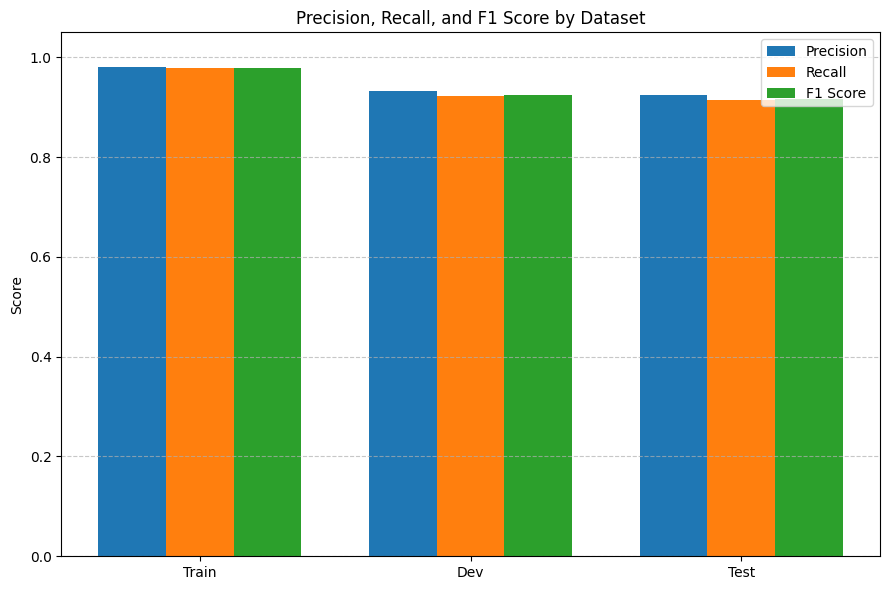

In [63]:
plot_precision_recall_f1(train_preds, train_labels, dev_preds, dev_labels, test_preds, test_labels)

In [64]:
def plot_confusion_matrices(dev_preds, dev_labels, test_preds, test_labels, class_names=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    cm_dev = confusion_matrix(dev_labels, dev_preds)
    cm_test = confusion_matrix(test_labels, test_preds)

    ConfusionMatrixDisplay(cm_dev, display_labels=class_names).plot(ax=axs[0], values_format='d')
    axs[0].set_title('Dev Set Confusion Matrix')

    ConfusionMatrixDisplay(cm_test, display_labels=class_names).plot(ax=axs[1], values_format='d')
    axs[1].set_title('Test Set Confusion Matrix')

    plt.tight_layout()
    plt.show()


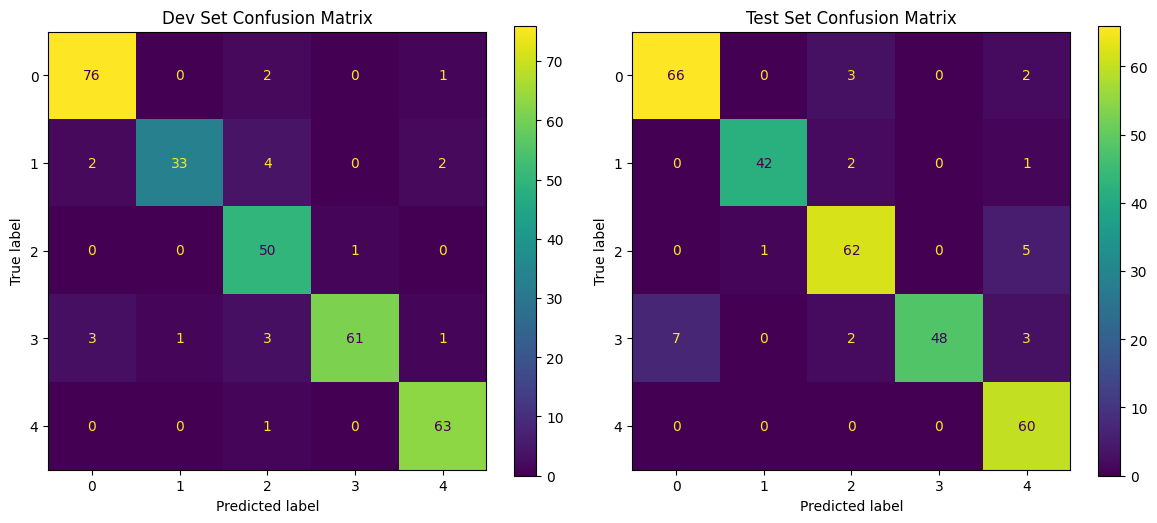

In [65]:
plot_confusion_matrices(dev_preds, dev_labels, test_preds, test_labels,)

In [66]:
def plot_loss_accuracy(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axis sharing the same x-axis
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(epochs, train_accuracies, label='Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title("Training Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()

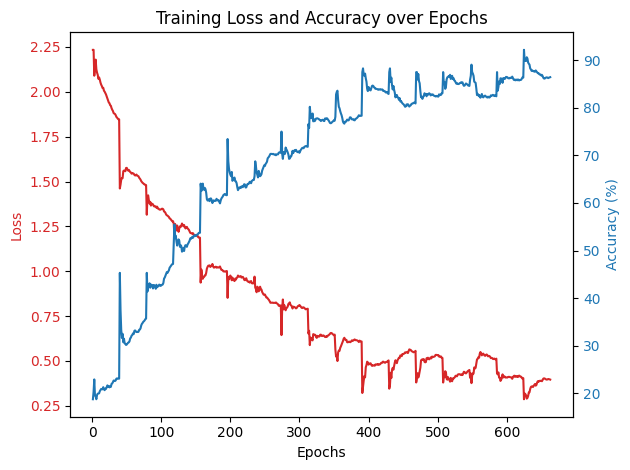

In [67]:
plot_loss_accuracy(train_losses, train_accuracies)

In [68]:

def show_random_predictions(model, dataset, class_names, device, num_samples=5):
    model.eval()
    model.to(device)

    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]

    images, labels = zip(*samples)
    images_tensor = torch.stack(images).to(device)
    labels_tensor = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images_tensor)
        _, preds = torch.max(outputs, 1)

    # Plotting the images with predictions
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_names[preds[i]]}, Actual: {class_names[labels_tensor[i]]}")
        plt.show()

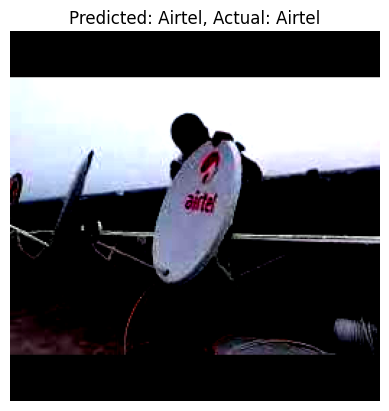

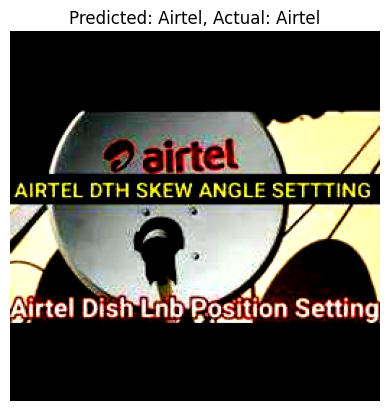

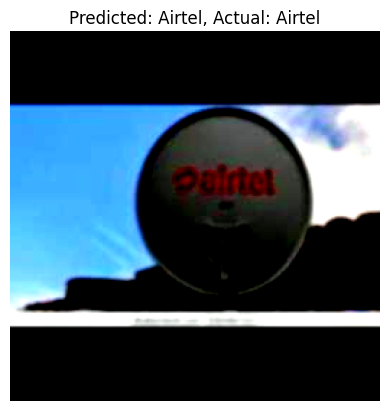

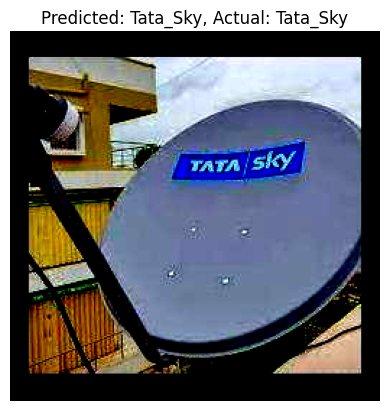

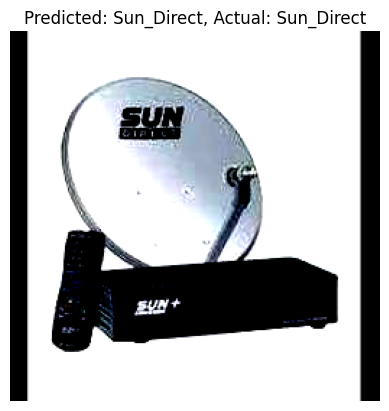

In [69]:
show_random_predictions(model, normalized_dataset, class_names, device, num_samples=5)

In [46]:
#k-fold Cross validation version

def run_kfold_training(normalized_dataset, num_epochs=10, k=5, batch_size=32, num_classes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_size = len(normalized_dataset)
    test_size = int(0.1 * total_size)
    train_val_size = total_size - test_size

    train_val_dataset, test_dataset = random_split(normalized_dataset, [train_val_size, test_size])

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_train_losses = []
    fold_train_accuracies = []
    fold_val_losses = []
    fold_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
        print(f"\n--- Fold {fold+1}/{k} ---")

        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

        model = CustomCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-5, betas=(0.9, 0.999))

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            epoch_loss, epoch_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            print(f"Train -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

        print(f"Final Val -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        fold_train_losses.append(epoch_loss)
        fold_train_accuracies.append(epoch_acc)
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_acc)

    return fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies


In [47]:
num_epochs = int(input("Enter number of epochs: "))

fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies = run_kfold_training(
    normalized_dataset=normalized_dataset,
    num_epochs=num_epochs,
    k=5,
    batch_size=64,
    num_classes=5
)

KeyboardInterrupt: Interrupted by user

In [23]:
print("Average training loss of 5 folds and 15 epochs ", sum(fold_train_losses)/len(fold_train_losses))
print("Average training accuracy of 5 folds and 15 epochs ", sum(fold_train_accuracies)/len(fold_train_accuracies))
print("Average validation loss of 5 folds and 15 epochs ", sum(fold_val_losses)/len(fold_val_losses))
print("Average validation accuracy of 5 folds and 15 epochs ", sum(fold_val_accuracies)/len(fold_val_accuracies))

Average training loss of 5 folds and 15 epochs  0.10642398360617127
Average training accuracy of 5 folds and 15 epochs  96.51966507752758
Average validation loss of 5 folds and 15 epochs  0.22971997470820243
Average validation accuracy of 5 folds and 15 epochs  93.25768151782272
